## Data preparation

In [84]:
!wget http://files.grouplens.org/datasets/movielens/ml-1m.zip > /dev/null 2>&1
!unzip ml-1m.zip > /dev/null 2>&1
!rm ml-1m.zip > /dev/null 2>&1

Обосновать: нет машинок для обучения -> для обучения за разумное время (0.5 - 1.0 часа) необходимо взять маленький датасет и ужимать кол-во эпох, movielens для этого отлично подходит + стандартность датасета позволит примерно оценить (по метрикам) качество обучаемых алгоритмов

In [127]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import random
from copy import deepcopy
from torch.utils.data import DataLoader, Dataset
import torch
import math
import pandas as pd
import torch.optim as optim
from tqdm.auto import tqdm
from torch.nn.parallel import data_parallel
from collections import defaultdict
import torch.optim.lr_scheduler as sched
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [125]:
movie_info = pd.read_csv('ml-1m/movies.dat', delimiter='::', header=None, names=['itemId', 'name', 'category'], engine='python')

In [68]:
data = pd.read_csv('ml-1m/ratings.dat', sep='::', header=None, names=['uid', 'mid', 'rating', 'timestamp'])

user_id = data[['uid']].drop_duplicates().reindex()
user_id['userId'] = np.arange(len(user_id))
data = pd.merge(data, user_id, on=['uid'], how='left')

item_id = data[['mid']].drop_duplicates()
item_id['itemId'] = np.arange(len(item_id))
data = pd.merge(data, item_id, on=['mid'], how='left')

data = data[['userId', 'itemId', 'rating', 'timestamp']]
data

,userId,itemId,rating,timestamp
0,0,0,5,978300760
1,0,1,3,978302109
2,0,2,3,978301968
3,0,3,4,978300275
4,0,4,5,978824291
...,...,...,...,...
1000204,6039,772,1,956716541
1000205,6039,1106,5,956704887
1000206,6039,365,5,956704746
1000207,6039,152,4,956715648


In [69]:
N_NEGATIVES = 4

    
class SimpleDataloder:  # works better here, cause collate_fn for this type of data are too slow than simply take slices
    
    def __iter__(self):
        return self

    def __init__(self, *elems):
        self.elems = elems
        self.counter = 0
        self.n_elems = len(self.elems[0])
    
    def set_bs(self, bs):
        self.bs = bs
        self.n_batches = self.n_elems // bs
        return self

    def __next__(self):
        if self.counter < self.n_batches:
            a, b = self.counter * self.bs, (self.counter + 1) * self.bs
            self.counter += 1
            return [elem[a:b] for elem in self.elems]
        else:
            raise StopIteration
    

bin_data = deepcopy(data)
bin_data['rating'][bin_data['rating'] > 0] = 1.0

users = set(data['userId'].unique())
items = set(data['itemId'].unique())

neg_data = data.groupby('userId')['itemId'].apply(set).reset_index().rename(columns={'itemId': 'interacted_items'})
neg_data['negative_items'] = neg_data['interacted_items'].apply(lambda x: items - x)
neg_data['negative_samples'] = neg_data['negative_items'].apply(lambda x: random.sample(x, 99))
neg_data = neg_data[['userId', 'negative_items', 'negative_samples']]

bin_data['rank_latest'] = bin_data.groupby(['userId'])['timestamp'].rank(method='first', ascending=False)
train_data, dev_data = bin_data[bin_data['rank_latest'] > 1], bin_data[bin_data['rank_latest'] == 1]
train_data, dev_data = train_data[['userId', 'itemId', 'rating']], dev_data[['userId', 'itemId', 'rating']]

# train
u, i, t = [], [], []
d = pd.merge(train_data, neg_data[['userId', 'negative_items']], on='userId')
d['negatives'] = d['negative_items'].apply(lambda x: random.sample(x, N_NEGATIVES))

for row in d.itertuples():
    u.append(int(row.userId))
    i.append(int(row.itemId))
    t.append(float(row.rating))

    for j in range(N_NEGATIVES):
        u.append(int(row.userId))
        i.append(int(row.negatives[j]))
        t.append(0.)

train_d = [torch.LongTensor(u), torch.LongTensor(i), torch.FloatTensor(t)]

# dev
d = pd.merge(dev_data, neg_data[['userId', 'negative_samples']], on='userId')
u, i, nu, ni = [], [], [], []

for row in d.itertuples():
    u.append(int(row.userId))
    i.append(int(row.itemId))

    for j in range(len(row.negative_samples)):
        nu.append(int(row.userId))
        ni.append(int(row.negative_samples[j]))

dev_d = [torch.LongTensor(u), torch.LongTensor(i), torch.LongTensor(nu), torch.LongTensor(ni)]

n_users, n_items = len(users), len(items)

In [70]:
n_users, n_items

(6040, 3706)

## Abstract class for models

In [137]:
class Trainer:

    def __init__(self, model, device, train_d, dev_d, epochs, lr, ngpus, bs, sched_gamma, wd):
        self.model = model
        self.device = device
        self.train_d = train_d
        self.dev_d = dev_d
        self.epochs = epochs
        self.lr = lr
        self.criterion = torch.nn.BCELoss()
        self.top_k = 10
        self.ngpus = ngpus
        self.bs = bs
        self.sched_gamma = sched_gamma
        self.wd = wd
    
    def _optim_step(self, loss):
        self.optim.zero_grad()
        loss.backward()
        self.optim.step()
    
    def _on_device(self, *elems):
        return [e.to(self.device) for e in elems]
    
    def _off_device(self, *elems):
        return [e.detach().cpu() for e in elems]

    def _run_model(self, u, i):
        if self.ngpus > 1:
            return data_parallel(self.model, (u, i), device_ids=list(range(self.ngpus)))
        return self.model(u, i) 
    
    def _train(self):
        self.model.train()
        total_loss = 0.
        
        dl = SimpleDataloder(*self.train_d).set_bs(self.bs)

        pbar = tqdm(dl, total=dl.n_batches, leave=False)
        for batch in pbar:
            users, items, targets = self._on_device(*batch)
            
            pred = self._run_model(users, items)
            assert pred.size() == targets.size(), f"{pred.size()}, {targets.size()}"
            loss = self.criterion(pred, targets)
            pbar.set_description(f"Loss: {loss.item():.3f}")
            self._optim_step(loss)
            total_loss += loss * len(users)

        self.train_logs['loss'].append(total_loss.item() / dl.n_elems)
    
    @torch.no_grad()
    def _test(self):
        self.model.eval()
        u, i, nu, ni = self._on_device(*self.dev_d)  # unpack dev data

        pred = self._run_model(u, i)
        neg_pred = self._run_model(nu, ni)

        u, i, pred = self._off_device(u, i, pred)
        nu, ni, neg_pred = self._off_device(nu, ni, neg_pred)

        hr, ndcg = self._calc_metrics(u, i, pred, nu, ni, neg_pred)

        self.dev_logs['HRs'].append(hr)
        self.dev_logs['NDCGs'].append(ndcg)
        self.pbar.set_description(f"HR: {hr:.2f} | NDCG: {ndcg:.2f}")
    
    def _calc_metrics(self, *elems):
        u, i, pred, nu, ni, neg_pred = [e.view(-1).tolist() for e in elems]

        combine = pd.merge(
            pd.DataFrame({'u': nu + u, 'i': ni + i, 'pred': neg_pred + pred}),
            pd.DataFrame({'u': u, '_i': i, '_pred': pred}), on=['u'], how='left')

        combine['r'] = combine.groupby('u')['pred'].rank(method='first', ascending=False)
        combine.sort_values(['u', 'r'], inplace=True)
        
        topk = combine[combine['r'] <= self.top_k]
        topk_oni = topk[topk['_i'] == topk['i']]
        n_uniqs = combine['u'].nunique()
        # HR @ 10
        hr = len(topk_oni) * 1.0 / n_uniqs
        # NDCG @ 10
        ndcg = topk_oni['r'].apply(lambda x: math.log(2) / math.log(1 + x)).sum() * 1.0 / n_uniqs

        return hr, ndcg
    
    def _prepare_tools(self):
        self.optim = optim.Adam(self.model.parameters(), lr=self.lr, weight_decay=self.wd)
        self.sched = sched.ExponentialLR(self.optim, self.sched_gamma)
        self.train_logs = defaultdict(list)
        self.dev_logs = defaultdict(list)
    
    def run(self):
        self._prepare_tools()

        self.pbar = tqdm(range(self.epochs), leave=False)
        for epoch in self.pbar:
            self._train()
            self._test()
    
    def calc_metrics(self):
        fig, (ax1, ax2) = plt.subplots(1, 2)
        
        y = self.dev_logs['HRs']
        x = list(range(len(y)))
        ax1.plot(x, y, 'tab:green')
        ax1.set_title('HR @ 10')
        
        y = self.dev_logs['NDCGs']
        x = list(range(len(y)))
        ax2.plot(x, y, 'tab:orange')
        ax2.set_title('NDCG @ 10')
        
    def similar(self, item_id, k=10):
        allitems_repr = self.model.allitems_repr()  # (n_items, d_emb)
        item_repr = self.model.item_repr(item_id)  # (1, d_emb)
        
        scores = (allitems_repr * item_repr).sum(axis=1)
        sim = list(reversed(np.argsort(scores)))[:k]
        
        print(f"{sim} items are similar to {item_id} item")
            
    def recommend(self, user_id, k=10):
        scores = self.model.pred_for_single_user(user_id)
        rec = list(reversed(np.argsort(scores)))[:k]
        
        print(f"{rec} items are recomended to {user_id} user")
    
    # knowing initial indexing we can extract movie names
    
#     def similars(self, item_id=1):
#         return [movie_info[movie_info["itemId"] == x[0]]["name"].to_string() for x in self.similar(item_id)]
    
#     def recomendations(self, user_id=1):
#         return [movie_info[movie_info["itemId"] == x[0]]["name"].to_string() for x in self.recommend(user_id)]

## 1 MF (GMF)

In [ ]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
EPOCHS = 40
LR = 2e-3
D_HIDDEN = 8
BS = 2048
N_GPUS = 1
SCHED_GAMMA = 0.95
WD = 0.  # 1e-3


class GMF(torch.nn.Module):
    """ General Matrix Factorization """
    def __init__(self, n_users, n_items, d_hidden):
        super().__init__()
        self.emb_user = nn.Embedding(n_users, d_hidden)
        self.emb_item = nn.Embedding(n_items, d_hidden)
        self.ff = nn.Linear(d_hidden, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, u, i):
        u_emb = self.emb_user(u)
        i_emb = self.emb_item(i)
        prod = torch.mul(u_emb, i_emb)
        out = self.sigmoid(self.ff(prod).squeeze(-1))
        return out
    
    @torch.no_grad()
    def allitems_repr(self):
        device = next(self.parameters()).device
        all_items = torch.tensor(list(range(n_items)), dtype=torch.long).to(device)
        return self.emb_item(all_items).cpu().numpy()
    
    @torch.no_grad()
    def item_repr(self, item_id):
        device = next(self.parameters()).device
        item = torch.tensor([item_id], dtype=torch.long).to(device)
        return self.emb_item(item).cpu().numpy()
    
    @torch.no_grad()
    def pred_for_single_user(self, user_id):
        device = next(self.parameters()).device
        items = torch.tensor(list(range(n_items)), dtype=torch.long).to(device)
        user_copies = torch.tensor([user_id for _ in range(len(items))], dtype=torch.long).to(device)
        return self(user_copies, items).cpu().numpy()


# train_dl = DataLoader(train_d, batch_size=BS, shuffle=True, num_workers=N_WORKERS, pin_memory=True)  # custom dl work better here
model = GMF(n_users=n_users, n_items=n_items, d_hidden=D_HIDDEN).to(DEVICE)
trainer = Trainer(model, DEVICE, train_d, dev_d, EPOCHS, LR, N_GPUS, BS, SCHED_GAMMA, WD)
trainer.run()

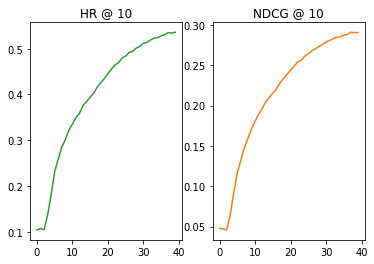

In [173]:
trainer.calc_metrics()

In [174]:
trainer.recommend(5)
trainer.similar(5)

[104, 116, 134, 124, 51, 128, 171, 48, 26, 167] items are recomended to 5 user
[124, 44, 104, 64, 132, 97, 22, 127, 113, 128] items are similar to 5 item


## 2 NMF

In [ ]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
EPOCHS = 40
LR = 2e-3
D_HIDDEN_MF = 8
D_HIDDEN_MLP = 8
LAYERS = [16, 32, 16, 8]
BS = 2048
N_GPUS = 1
SCHED_GAMMA = 0.95
WD = 0.  # 1e-3


class NMF(torch.nn.Module):
    """ Neural Matrix Factorization """
    def __init__(self, n_users, n_items, d_hidden_mlp, d_hidden_mf, layers):
        super().__init__()
        self.emb_user_mlp = nn.Embedding(n_users, d_hidden_mlp)
        self.emb_item_mlp = nn.Embedding(n_items, d_hidden_mlp)
        self.emb_user_mf = nn.Embedding(n_users, d_hidden_mf)
        self.emb_item_mf = nn.Embedding(n_items, d_hidden_mf)
        
        ff = []
        layers = [d_hidden_mlp + d_hidden_mf] + layers
        for a, b in zip(layers[:-1], layers[1:]):
            ff.append(nn.Linear(a, b))        
        self.ff_mlp = nn.Sequential(*ff)

        self.ff = nn.Linear(layers[-1] + d_hidden_mf, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, user_indices, item_indices):
        u_emb_mlp = self.emb_user_mlp(user_indices)
        i_emb_mlp = self.emb_item_mlp(item_indices)
        u_emb_mf = self.emb_user_mf(user_indices)
        i_emb_mf = self.emb_item_mf(item_indices)

        emb_mlp = torch.cat([u_emb_mlp, i_emb_mlp], dim=-1)
        emb_mlp = self.ff_mlp(emb_mlp)
        
        emb_mf = torch.mul(u_emb_mf, i_emb_mf)
        emb = torch.cat([emb_mlp, emb_mf], dim=-1)
        
        return self.sigmoid(self.ff(emb).view(-1))
    
    @torch.no_grad()
    def allitems_repr(self):
        device = next(self.parameters()).device
        all_items = torch.tensor(list(range(n_items)), dtype=torch.long).to(device)
        mlp = self.emb_item_mlp(all_items)
        mf = self.emb_item_mf(all_items)
        return torch.cat([mlp, mf], dim=-1).cpu().numpy()
    
    @torch.no_grad()
    def item_repr(self, item_id):
        device = next(self.parameters()).device
        item = torch.tensor([item_id], dtype=torch.long).to(device)
        mlp = self.emb_item_mlp(item)
        mf = self.emb_item_mf(item)
        return torch.cat([mlp, mf], dim=-1).cpu().numpy()
    
    @torch.no_grad()
    def pred_for_single_user(self, user_id):
        device = next(self.parameters()).device
        items = torch.tensor(list(range(n_items)), dtype=torch.long).to(device)
        user_copies = torch.tensor([user_id for _ in range(len(items))], dtype=torch.long).to(device)
        return self(user_copies, items).cpu().numpy()

    
model = NMF(n_users=n_users, n_items=n_items, d_hidden_mlp=D_HIDDEN_MLP, d_hidden_mf=D_HIDDEN_MF, layers=LAYERS).to(DEVICE)
trainer = Trainer(model, DEVICE, train_d, dev_d, EPOCHS, LR, N_GPUS, BS, SCHED_GAMMA, WD)
trainer.run()

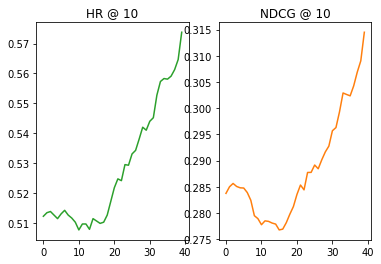

In [182]:
trainer.calc_metrics()

In [183]:
trainer.recommend(5)
trainer.similar(5)

[171, 116, 729, 134, 40, 547, 124, 48, 189, 167] items are recomended to 5 user
[44, 5, 124, 64, 113, 22, 104, 669, 151, 26] items are similar to 5 item


## 3 Simple Attention

In [ ]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
EPOCHS = 40
LR = 2e-3
D_HIDDEN_MF = 8
D_HIDDEN_MLP = 8
LAYERS = [16, 32, 16, 8]
BS = 2048
N_GPUS = 1
SCHED_GAMMA = 0.95
WD = 0.  # 1e-3


class SimpleAttention(torch.nn.Module):
    """ Simple Attention """
    def __init__(self, n_users, n_items, d_hidden_mlp, d_hidden_mf, layers):
        super().__init__()
        self.emb_user_mlp = nn.Embedding(n_users, d_hidden_mlp)
        self.emb_item_mlp = nn.Embedding(n_items, d_hidden_mlp)
        self.emb_user_mf = nn.Embedding(n_users, d_hidden_mf)
        self.emb_item_mf = nn.Embedding(n_items, d_hidden_mf)
        
        self.mh = nn.MultiHeadAttention(d_hidden_mlp + d_hidden_mf, num_heads=4)
        
        ff = []
        layers = [d_hidden_mlp + d_hidden_mf] + layers
        for a, b in zip(layers[:-1], layers[1:]):
            ff.append(nn.Linear(a, b))        
        self.ff_mlp = nn.Sequential(*ff)

        self.ff = nn.Linear(layers[-1] + d_hidden_mf, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, user_indices, item_indices):
        u_emb_mlp = self.emb_user_mlp(user_indices)
        i_emb_mlp = self.emb_item_mlp(item_indices)
        u_emb_mf = self.emb_user_mf(user_indices)
        i_emb_mf = self.emb_item_mf(item_indices)

        emb_mlp = torch.cat([u_emb_mlp, i_emb_mlp], dim=-1)
        emb_mlp = self.mh(emb_mlp)
        emb_mlp = self.ff_mlp(emb_mlp)
        
        emb_mf = torch.mul(u_emb_mf, i_emb_mf)
        emb = torch.cat([emb_mlp, emb_mf], dim=-1)
        
        return self.sigmoid(self.ff(emb).view(-1))

    
model = SimpleAttention(n_users=n_users, n_items=n_items, d_hidden_mlp=D_HIDDEN_MLP, d_hidden_mf=D_HIDDEN_MF, layers=LAYERS).to(DEVICE)
trainer = Trainer(model, DEVICE, train_d, dev_d, EPOCHS, LR, N_GPUS, BS, SCHED_GAMMA, WD)
trainer.run()

In [ ]:
trainer.calc_metrics()

In [ ]:
trainer.recommend(5)
trainer.similar(5)